In [8]:
'''
02_filter-data.ipynb
Filter the data for the analysis
'''

import pathlib
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points, cascaded_union
import h3
import matplotlib.pyplot as plt

PATH_ROOT = os.path.join(pathlib.Path().absolute(), '../..' )
PATH_DATA_IN = PATH_ROOT + '/data/01_raw/'
PATH_DATA_OUT = PATH_ROOT + '/data/02_processed/'

os.makedirs(PATH_DATA_OUT) if not os.path.exists(PATH_DATA_OUT) else False

False

In [9]:
'''
Filter activities table
- Remove uncertain activities
- Remove activities where PO2 was not presented
'''

PATH_ACTIVITIES_IN = PATH_DATA_IN + 'activities.csv'

activities_all = pd.read_csv(PATH_ACTIVITIES_IN)
print(len(activities_all))

# filter only activities with locality defined
activities_all = activities_all[activities_all['lokalitat_name'].notnull()]


#print(activities_all['lokalitat_prazision'])
# filter only certain activities
activities_certain = activities_all[
    (
        (activities_all['sicherheit'] == 1) | 
        (activities_all['sicherheit'] == 2) | 
        (activities_all['sicherheit'] == 3)
    ) & (
        (activities_all['lokalitat_prazision'] == '1') |
        (activities_all['lokalitat_prazision'] == '2')
    )
]
print(len(activities_certain))

# get rid of all activities where po-ii was not presented 
activities_po_ii = activities_certain[(activities_certain['aussteller'] == 'M') | (activities_certain['aussteller'] == 'Ja') | (activities_certain['aussteller'] == '-')]
print(len(activities_po_ii))

# save only (for now) interesting columns
activities_po_ii = activities_po_ii[['no', 'sicherheit', 'datum_text', 'tag_post','monat_post','jahr_post','tag_ante','monat_ante','jahr_ante', 'lokalitat_name','lokalitat_agglomeration', 'lokalitat_politik', 'bi1_lokalitatname', 'bi2_lokalitatname', 'bi3_lokalitatname', 'bi4_lokalitatname', 'bi5_lokalitatname', 'gg1_lokalitatname', 'gg2_lokalitatname', 'gg3_lokalitatname', 'gg4_lokalitatname', 'gg5_lokalitatname', 'aussteller']]

# export table
activities_po_ii.to_csv(PATH_DATA_OUT + 'activities.csv')

1093
660
621


In [10]:
# get list of unique localities from the table of filtered activities

PATH_ACTIVITIES_IN = PATH_DATA_OUT + 'activities.csv'
PATH_PLACES_IN = PATH_DATA_IN + 'localities.csv'

activities = pd.read_csv(PATH_ACTIVITIES_IN)
places_all = pd.read_csv(PATH_PLACES_IN)

# add geometry attribute    
places_all['geometry'] = places_all.apply(
    lambda x: Point(x['y'], x['x']), axis=1
)
places_all = gpd.GeoDataFrame(places_all).set_geometry('geometry')
print(len(places_all))

# take only places that are listed in activities
destination_names = activities['lokalitat_name'].unique()
destinations = places_all[places_all['name'].isin(destination_names)]

# save as .csv
places_all.to_csv(PATH_DATA_OUT + 'localities.csv')
destinations.to_csv(PATH_DATA_OUT + 'destinations.csv')

# save as GeoJSON files also
places_all.to_file(PATH_DATA_OUT + 'localities.geojson',  driver="GeoJSON")
destinations.to_file(PATH_DATA_OUT + 'destinations.geojson',  driver="GeoJSON")

722


In [11]:
# create bounding box from the list of destinations

PATH_DESTINATIONS_IN = PATH_DATA_OUT + 'destinations.csv'
destinations = pd.read_csv(PATH_DESTINATIONS_IN)

destinations['geometry'] = destinations['geometry'].apply(wkt.loads)
destinations_geo = gpd.GeoDataFrame(destinations)

# extend the boundaries by BOUND_MARGIN parameter
BOUND_MARGIN = 0.2
dbb = destinations_geo.total_bounds

dbb_polygon = Polygon([
    [dbb[0] - BOUND_MARGIN, dbb[1] - BOUND_MARGIN], 
    [dbb[0] - BOUND_MARGIN, dbb[3] + BOUND_MARGIN], 
    [dbb[2] + BOUND_MARGIN, dbb[3] + BOUND_MARGIN], 
    [dbb[2] + BOUND_MARGIN, dbb[1] - BOUND_MARGIN], 
    [dbb[0] - BOUND_MARGIN, dbb[1] - BOUND_MARGIN]
])
bbox = gpd.GeoDataFrame([{'geometry': dbb_polygon}])
bbox.to_file(PATH_DATA_OUT + 'bbox.geojson', driver="GeoJSON")


In [12]:
# clip srtm to the bounding box

PATH_IN_SRTM = PATH_DATA_IN + 'srtm/merged.tif'
PATH_OUT_SRTM = PATH_DATA_OUT + 'elevation.tif'

print(PATH_IN_SRTM)

if os.path.isfile(PATH_OUT_SRTM):
    os.remove(PATH_OUT_SRTM)

PATH_BBOX = PATH_DATA_OUT + 'bbox.geojson'
bbox = gpd.read_file(PATH_BBOX)

hex_distance = 2 * h3.edge_length(9)
#hex_distance_grades = hex_distance / 111
hex_distance_grades = 0.15

bounds = bbox.total_bounds

os.system("gdalwarp -tr {} {} -te {} {} {} {} -t_srs EPSG:4326 -co COMPRESS=LZW -r min {} {}".format(
    hex_distance / 111, hex_distance / 111, 
    bounds[0], bounds[1], bounds[2], bounds[3],
    PATH_IN_SRTM, PATH_OUT_SRTM
))


/home/adam/projects/itinerary-analysis_PO2-case-study/src/processing/../../data/01_raw/srtm/merged.tif
Creating output file that is 2980P x 3001L.
Processing /home/adam/projects/itinerary-analysis_PO2-case-study/src/processing/../../data/01_raw/srtm/merged.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


0

<AxesSubplot:>

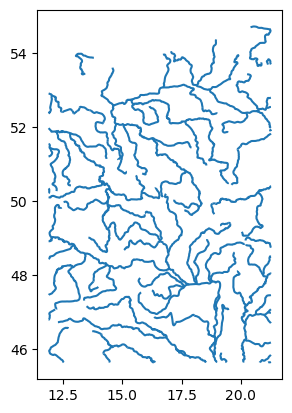

In [13]:
# clip rivers to the bounding box

PATH_RIVERS_IN = PATH_DATA_IN + 'rivers/rivers.geojson'
PATH_BBOX = PATH_DATA_OUT + 'bbox.geojson'

rivers = gpd.read_file(PATH_RIVERS_IN)
bbox = gpd.read_file(PATH_BBOX)
rivers_clip = gpd.clip(rivers, bbox)

rivers_clip.to_file(PATH_DATA_OUT + 'rivers.geojson', driver="GeoJSON")
rivers_clip.plot()

/home/adam/miniconda3/envs/po2/lib/python3.9/site-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<AxesSubplot:>

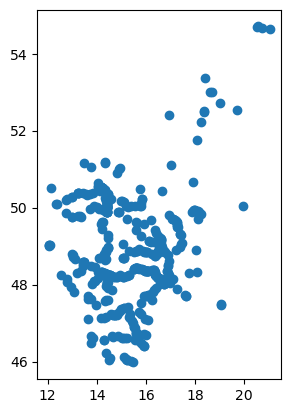

In [14]:
# create a list of bridges

CONST_distance_bridge = 12 / 111

PATH_LOCALITIES_IN = PATH_DATA_OUT + 'localities.geojson'
PATH_RIVERS_IN = PATH_DATA_OUT + 'rivers.geojson'

# load all certain places
places_all = gpd.read_file(PATH_LOCALITIES_IN)
places_certain = places_all[places_all['prazision'] == 1]

# load rivers
rivers = gpd.read_file(PATH_RIVERS_IN)

bridges_ps = []
for si, stop in places_certain.iterrows():
    if stop['geometry']:
        stop_buffer = stop['geometry'].buffer(CONST_distance_bridge)
        #print (stop_buffer)
        for ri, river in rivers.iterrows():
            if river['geometry'].crosses(stop_buffer):
                bridge_p = nearest_points(stop['geometry'], river['geometry'])[1]
                bridges_ps.append(bridge_p)

#bridges = cascaded_union([b.buffer(hex_distance / 222) for b in bridges_ps])

# export bridges
bridges_gdf = gpd.GeoDataFrame([{"geometry": bridge} for bridge in bridges_ps], crs={'init': 'epsg:4326'}, geometry='geometry')
bridges_gdf.to_file(PATH_DATA_OUT + 'bridges.geojson', driver='GeoJSON')

bridges_gdf.plot()